# GAN for Cybersecurity

In [1]:
# Import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sklearn

# Dataset pre-processing

In [2]:
# Import dataset
path_training = "Training and Testing Sets/UNSW_NB15_training-set.csv"
path_testing = "Training and Testing Sets/UNSW_NB15_testing-set.csv"
df_train = pd.read_csv(path_training)
df_test = pd.read_csv(path_testing)

print("Training set shape:", df_train.shape)
df_train.head()

Training set shape: (175341, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
print("Testing set shape:", df_test.shape)
df_test.head()

Testing set shape: (82332, 45)


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
# Convert categorical features to float
categorical_features = ['proto', 'service', 'state', 'attack_cat']
for feature in categorical_features:
    df_train[feature] = df_train[feature].astype('category').cat.codes
    df_test[feature] = df_test[feature].astype('category').cat.codes

# df shape
print("Training set shape after encoding:", df_train.shape)
print("Testing set shape after encoding:", df_test.shape)

Training set shape after encoding: (175341, 45)
Testing set shape after encoding: (82332, 45)


# Visualize Dataset repartition

Text(0.5, 1.0, 'Repartition of Normal and Anomalous Data in Training Set')

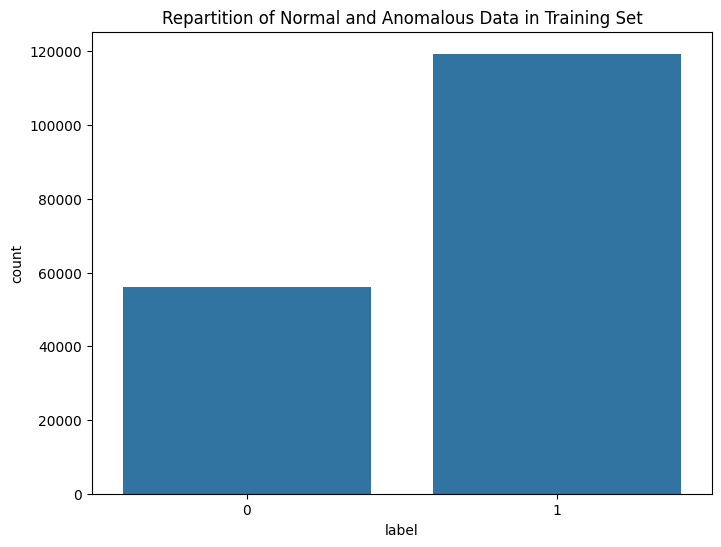

In [5]:
# Repartition of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df_train)
plt.title('Repartition of Normal and Anomalous Data in Training Set')

In [6]:
# print number of features and min and max values
print("Number of features:", df_train.shape[1])
feature_stats = []
for feature in df_train.columns:
    min_val = df_train[feature].min()
    max_val = df_train[feature].max()
    mean_val = df_train[feature].mean()
    feature_stats.append({'Feature': feature, 'Min': min_val, 'Max': max_val, 'Mean': mean_val})

feature_stats_df = pd.DataFrame(feature_stats)
print(feature_stats_df)


Number of features: 45
              Feature   Min           Max          Mean
0                  id   1.0  1.753410e+05  8.767100e+04
1                 dur   0.0  5.999999e+01  1.359389e+00
2               proto   0.0  1.320000e+02  1.096067e+02
3             service   0.0  1.200000e+01  1.618920e+00
4               state   0.0  8.000000e+00  2.355176e+00
5               spkts   1.0  9.616000e+03  2.029866e+01
6               dpkts   0.0  1.097400e+04  1.896959e+01
7              sbytes  28.0  1.296523e+07  8.844844e+03
8              dbytes   0.0  1.465555e+07  1.492892e+04
9                rate   0.0  1.000000e+06  9.540619e+04
10               sttl   0.0  2.550000e+02  1.795470e+02
11               dttl   0.0  2.540000e+02  7.960957e+01
12              sload   0.0  5.988000e+09  7.345403e+07
13              dload   0.0  2.242273e+07  6.712056e+05
14              sloss   0.0  4.803000e+03  4.953000e+00
15              dloss   0.0  5.484000e+03  6.948010e+00
16             sinpkt   0

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Directement MinMaxScaler en [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

df_train_scaled = pd.DataFrame(
    scaler.fit_transform(df_train.drop(columns=['label'])), 
    columns=df_train.columns.drop('label')
)
df_train_scaled['label'] = df_train['label'].values

df_test_scaled = pd.DataFrame(
    scaler.transform(df_test.drop(columns=['label'])), 
    columns=df_test.columns.drop('label')
)
df_test_scaled['label'] = df_test['label'].values

# Vérification
print("✅ Plages après MinMaxScaler:")
print(f"Train - Min: {df_train_scaled.drop(columns=['label']).min().min():.4f}, Max: {df_train_scaled.drop(columns=['label']).max().max():.4f}")

print("\nTraining set after normalization:")
print(df_train_scaled.head())

✅ Plages après MinMaxScaler:
Train - Min: -1.0000, Max: 1.0000

Training set after normalization:
         id       dur     proto  service  state     spkts     dpkts    sbytes  \
0 -1.000000 -0.995951  0.712121     -1.0   -0.5 -0.998960 -0.999271 -0.999965   
1 -0.999989 -0.978337  0.712121     -1.0   -0.5 -0.997296 -0.993075 -0.999891   
2 -0.999977 -0.945896  0.712121     -1.0   -0.5 -0.998544 -0.997084 -0.999948   
3 -0.999966 -0.943945  0.712121     -0.5   -0.5 -0.997712 -0.997813 -0.999907   
4 -0.999954 -0.985018  0.712121     -1.0   -0.5 -0.998128 -0.998907 -0.999922   

     dbytes      rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0 -0.999977 -0.999852  ...              -1.0        -1.00000          -1.0   
1 -0.994266 -0.999843  ...              -1.0        -0.96875          -1.0   
2 -0.998201 -0.999972  ...              -1.0        -0.93750          -1.0   
3 -0.999895 -0.999973  ...              -1.0        -0.93750          -0.5   
4 -0.999963 -0.999933  ..

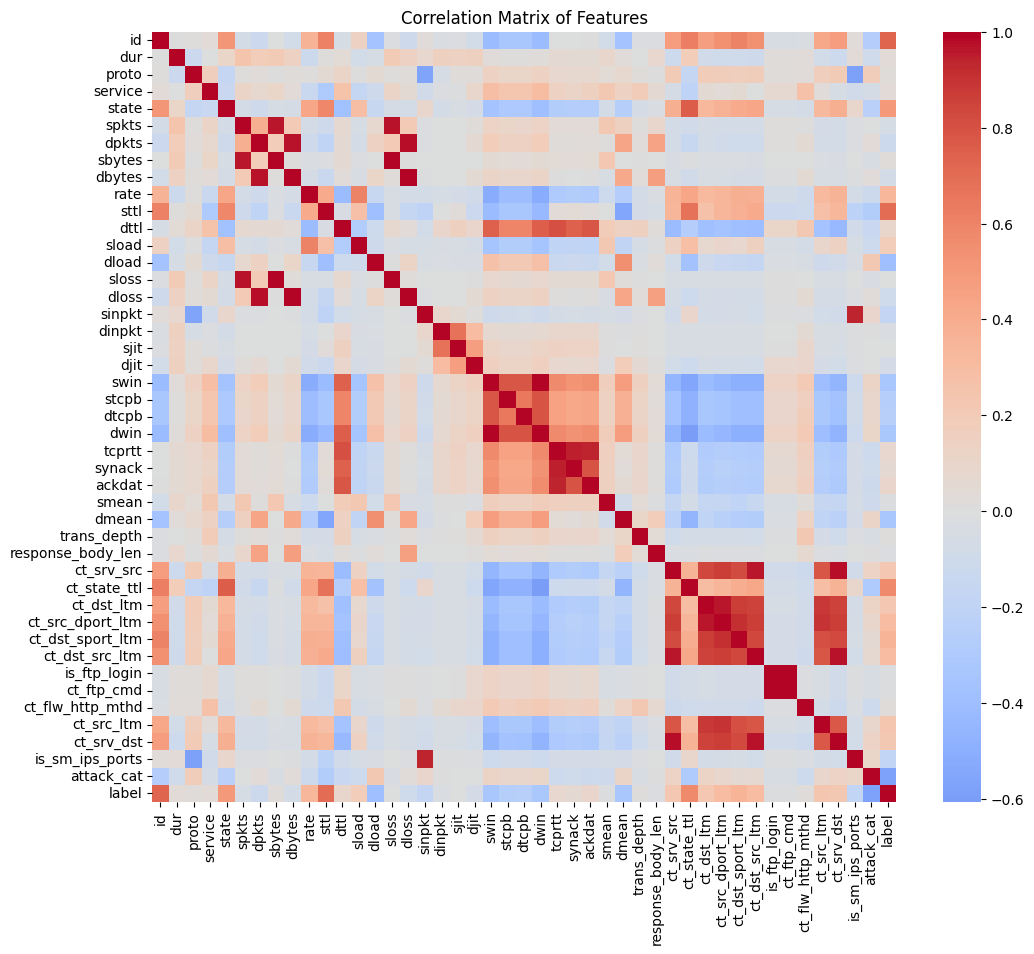

In [8]:
# correlation matrix for feature selection
corr_matrix = df_train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

In [9]:
# Determine important features
# Based on correlation with the label, we can select features with high absolute correlation values
important_features = corr_matrix['label'].abs().sort_values(ascending=False)
print("Important features based on correlation with label:\n", important_features)

# Select top N features (excluding the label itself)
N = 20
top_features = important_features.index[1:N+1].tolist()
print("Top {} features selected for training:\n".format(N), top_features)

# Prepare data for training
X_train = df_train[top_features]
y_train = df_train['label']
X_test = df_test[top_features]
y_test = df_test['label']
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("X_train after scaling shape:", X_train.shape)
print("X_test after scaling shape:", X_test.shape)

Important features based on correlation with label:
 label                1.000000
id                   0.727173
sttl                 0.692741
attack_cat           0.580908
ct_state_ttl         0.577704
state                0.497685
dload                0.393739
ct_dst_sport_ltm     0.357213
dmean                0.341806
rate                 0.337979
swin                 0.333633
dwin                 0.319626
ct_src_dport_ltm     0.305579
ct_dst_src_ltm       0.303855
stcpb                0.255006
dtcpb                0.250340
ct_src_ltm           0.238225
ct_dst_ltm           0.229887
ct_srv_src           0.229044
ct_srv_dst           0.228046
is_sm_ips_ports      0.184679
sload                0.182870
sinpkt               0.176110
dpkts                0.118591
ackdat               0.097364
dttl                 0.095049
dloss                0.094685
tcprtt               0.081584
dbytes               0.076871
djit                 0.060870
synack               0.058299
spkts            

# PREPARE THE GAN

In [10]:
# --- CREATE A STABLE GAN MODEL FOR TABULAR DATA ---

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

latent_dim = 32
input_dim = X_train.shape[1]

def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),  # ✅ Explicit input layer
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(output_dim, activation='tanh')  # or 'linear' depending on your data
    ])
    return model

def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),  # ✅ Explicit input layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


# =========================================
# 3️⃣ COMPILE MODELS
# =========================================
generator = build_generator(latent_dim, input_dim)
discriminator = build_discriminator(input_dim)

# Compile discriminator
discriminator.compile(
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Freeze D when training G
discriminator.trainable = False

# Build full GAN
gan_input = layers.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)
gan.compile(
    optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)

# =========================================
# 4️⃣ SUMMARIES
# =========================================
print("✅ Generator Summary:")
generator.summary()
print("\n✅ Discriminator Summary:")
discriminator.summary()


✅ Generator Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,924 (171.58 KB)

 Trainable params: 43,156 (168.58 KB)

 Non-trainable params: 768 (3.00 KB)


✅ Discriminator Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,401 (150.00 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 38,401 (150.00 KB)

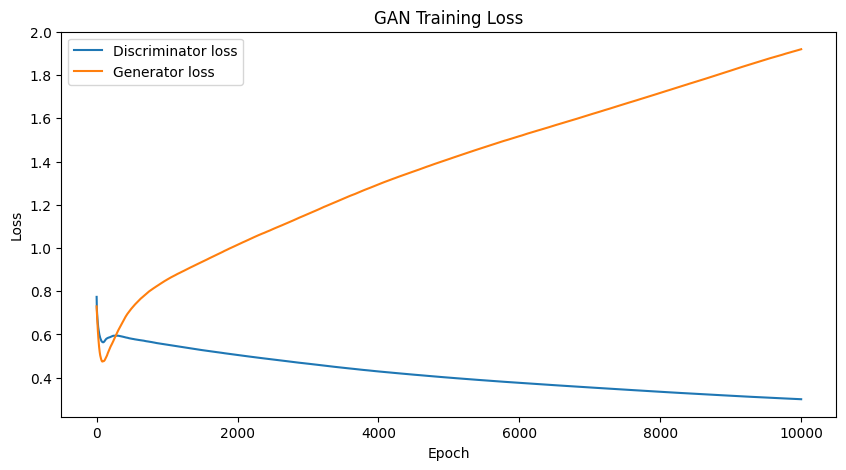


--- Generated samples at epoch 10000 ---


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19
0,-0.562361,0.722188,0.997960,0.716551,0.756476,-0.245719,-0.305800,-0.487139,0.011644,-0.878213,-0.866020,-0.276571,0.513216,-0.687544,-0.632335,-0.347217,-0.163687,0.298337,0.392510,-0.111395
1,0.756032,0.544978,-1.000000,-0.235681,-0.363912,-0.227031,-0.471214,-0.197309,-0.535412,0.997759,0.998532,-0.464598,-0.596892,0.249401,0.152003,-0.555774,-0.505997,-0.654822,-0.659102,-0.130398
2,0.757302,0.783208,-0.989011,0.757422,0.757843,-0.301314,-0.425421,-0.472657,0.303835,-0.943737,-0.954884,-0.433304,0.039879,-0.757300,-0.792067,-0.603416,-0.507167,-0.196520,-0.105305,-0.143367
3,-0.724894,0.786789,0.999999,-0.372508,-0.320318,-0.233970,-0.693734,-0.355487,-0.537479,1.000000,1.000000,-0.496912,-0.347859,0.943933,0.473547,-0.451550,-0.383047,0.356434,-0.539306,-0.118105
4,-0.598754,-0.440169,-0.999979,-0.327721,-0.207844,-0.225251,-0.535663,-0.087406,-0.533069,1.000000,1.000000,-0.463395,-0.639152,0.170106,1.000000,-0.186854,-0.527607,0.509930,-0.553248,-0.125717


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd

def train_gan_plot_samples(gan, generator, discriminator, X_train, latent_dim,
                           epochs=10000, batch_size=128, plot_interval=100, sample_interval=500, num_samples=5):
    """
    Train a GAN with real-time loss plots and periodic generated sample inspection.
    
    Parameters:
    - plot_interval: epochs between loss plot updates
    - sample_interval: epochs between sample data visualization
    - num_samples: how many generated samples to display
    """
    X_train = X_train.astype('float32')  # ensure numpy array
    half_batch = batch_size // 2
    
    d_losses, g_losses = [], []
    
    for epoch in range(1, epochs + 1):
        # ---------------------
        # Train Discriminator
        # ---------------------
        discriminator.trainable = True
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_data = X_train[idx]
        noise = np.random.normal(size=(half_batch, latent_dim))
        fake_data = generator(noise, training=False).numpy()
        
        d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((half_batch, 1)))
        d_loss = [0.5 * (d_loss_real[0] + d_loss_fake[0]),
                  0.5 * (d_loss_real[1] + d_loss_fake[1])]
        
        # ---------------------
        # Train Generator
        # ---------------------
        discriminator.trainable = False
        noise = np.random.normal(size=(batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)
        
        # ---------------------
        # Log losses
        # ---------------------
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # ---------------------
        # Print progress
        # ---------------------
        if epoch % 10 == 0:
            print(f"{epoch}/{epochs} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        
        # ---------------------
        # Plot losses in real time
        # ---------------------
        if epoch % plot_interval == 0 or epoch == 1:
            clear_output(wait=True)
            plt.figure(figsize=(10,5))
            plt.plot(d_losses, label='Discriminator loss')
            plt.plot(g_losses, label='Generator loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('GAN Training Loss')
            plt.legend()
            plt.show()
        
        # ---------------------
        # Generate and show sample data
        # ---------------------
        if epoch % sample_interval == 0 or epoch == 1:
            noise = np.random.normal(size=(num_samples, latent_dim))
            gen_samples = generator(noise, training=False).numpy()
            
            print(f"\n--- Generated samples at epoch {epoch} ---")
            # Convert to pandas DataFrame for nicer display
            df_samples = pd.DataFrame(gen_samples, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
            display(df_samples)
            
    return d_losses, g_losses

d_losses, g_losses = train_gan_plot_samples(
    gan, generator, discriminator,
    X_train, latent_dim,
    epochs=10000,        # smaller for testing
    batch_size=128,
    plot_interval=100,  # update loss plot every 100 epochs
    sample_interval=500,# show samples every 500 epochs
    num_samples=5       # 5 generated rows
)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Generated Data Sample:
              id        sttl  attack_cat  ct_state_ttl     state  \
0  60312.265625  194.165527    3.101882      1.072384  2.035207   
1  83157.515625  257.199127    5.258062      2.020590  2.991169   
2  97018.523438  258.653320    5.846572      1.066611  2.050951   
3  96603.875000   76.607300    3.540831      1.039809  1.973711   
4  47793.375000  256.940186    3.133685      1.990747  3.006496   

           dload  ct_dst_sport_ltm       dmean           rate        swin  \
0   35294.199219          1.300999   92.973099    3657.499512  243.257996   
1  -51391.925781          0.867670    0.222699  122638.328125   -1.256906   
2   13044.761719          1.499801   37.779362    4518.140137  242.326706   
3 -168453.796875         -0.191887  368.976166    5444.437012  243.257858   
4  -56570.800781          0.911247    0.726971   46570.128906   -2.209222   

         dwin  ct_src_dport_ltm  ct_dst_src_ltm         stcpb         d

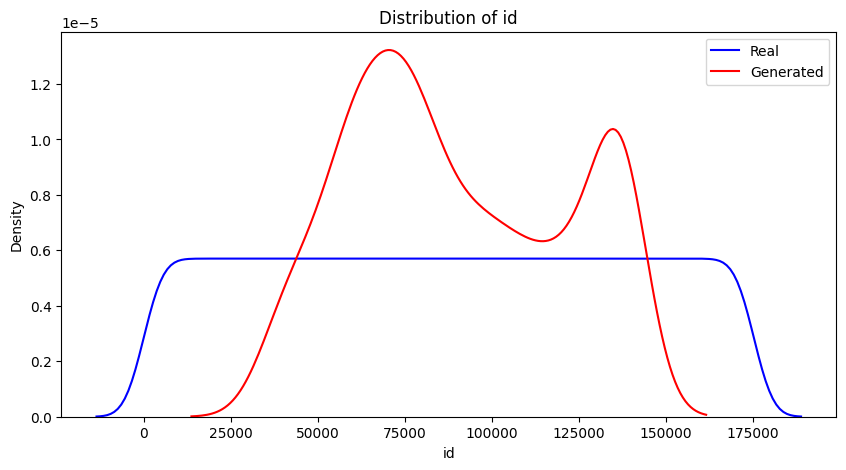

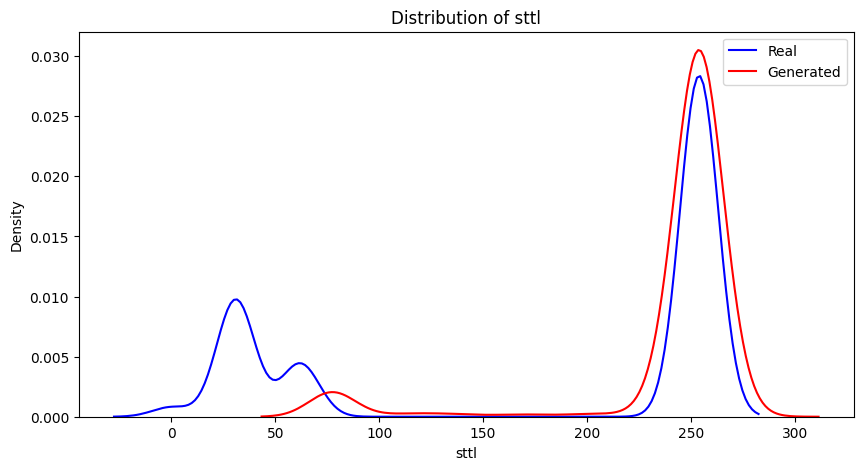

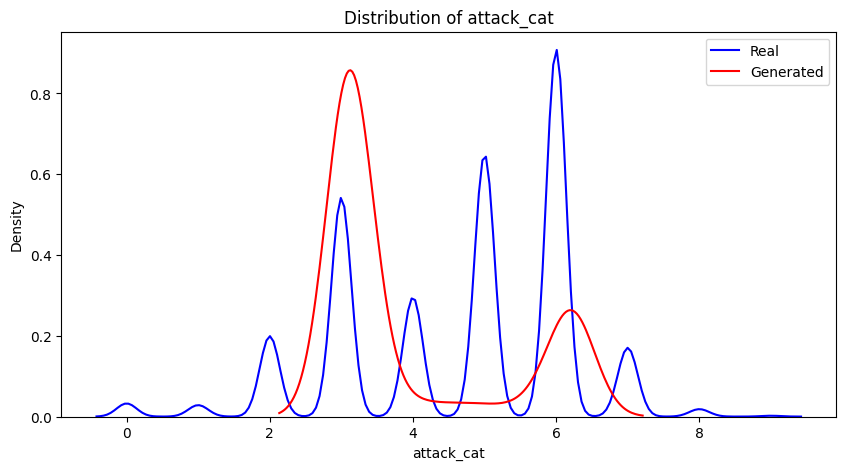

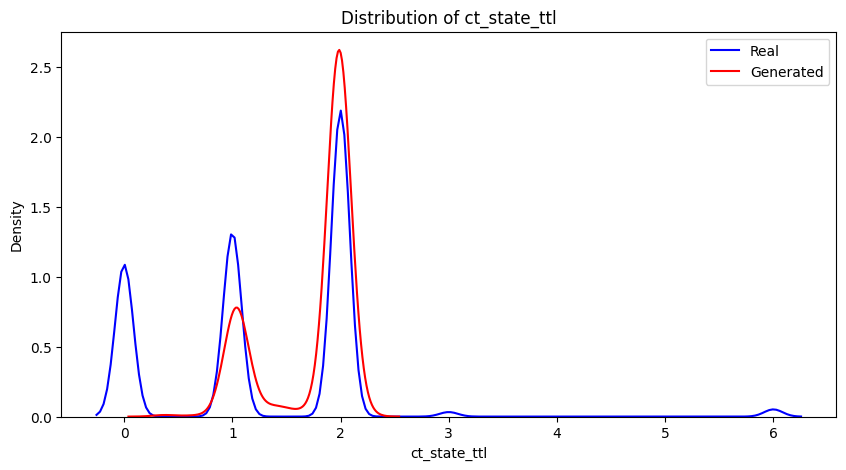

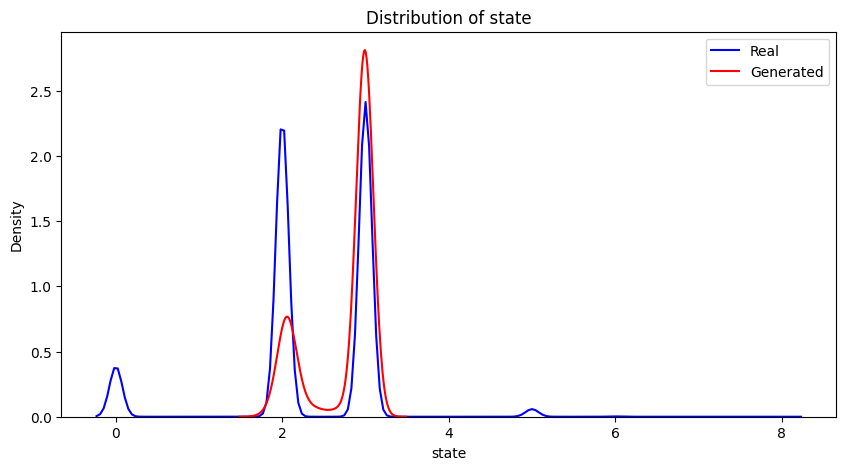

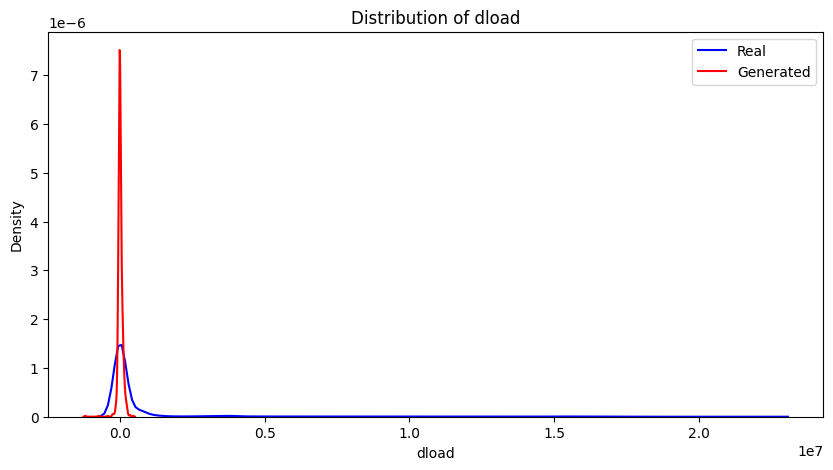

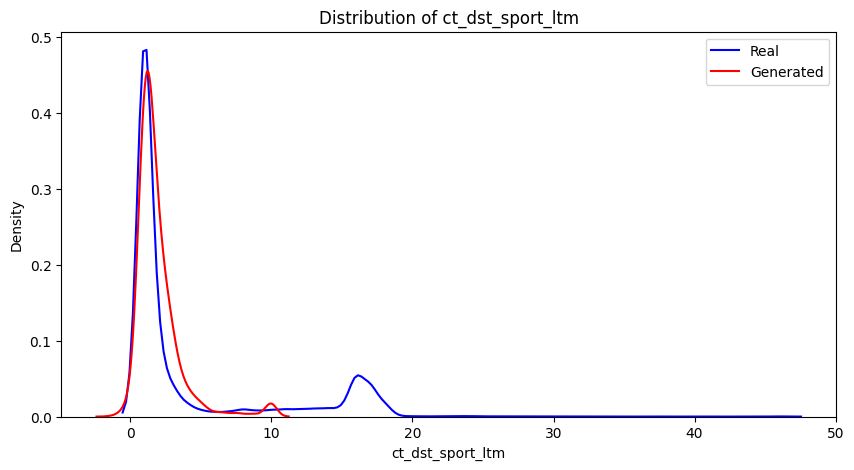

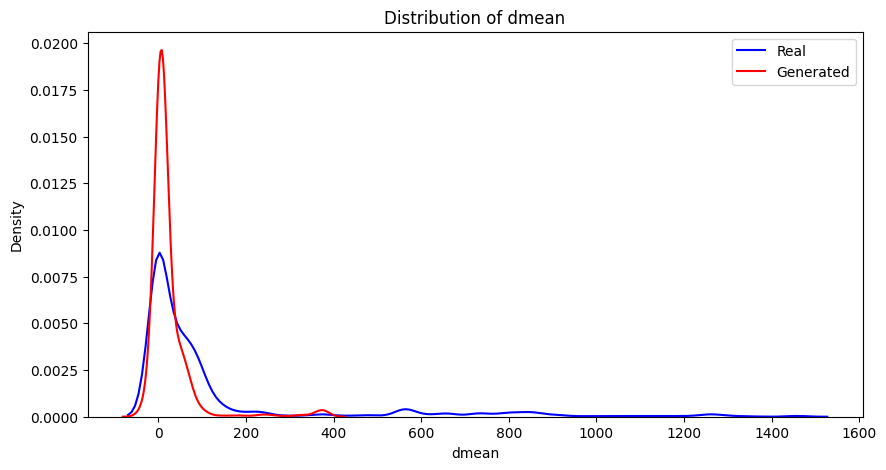

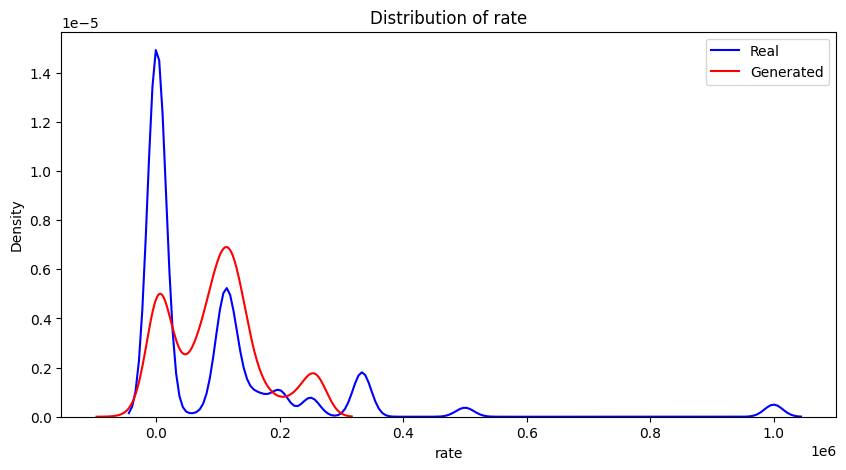

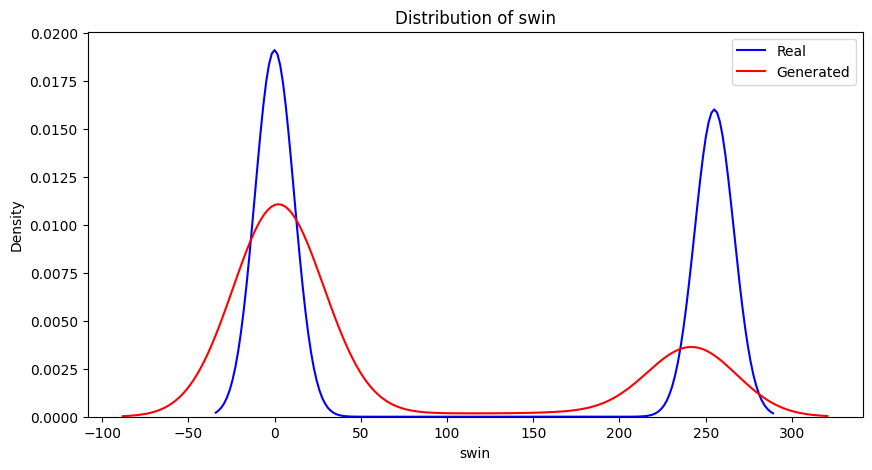

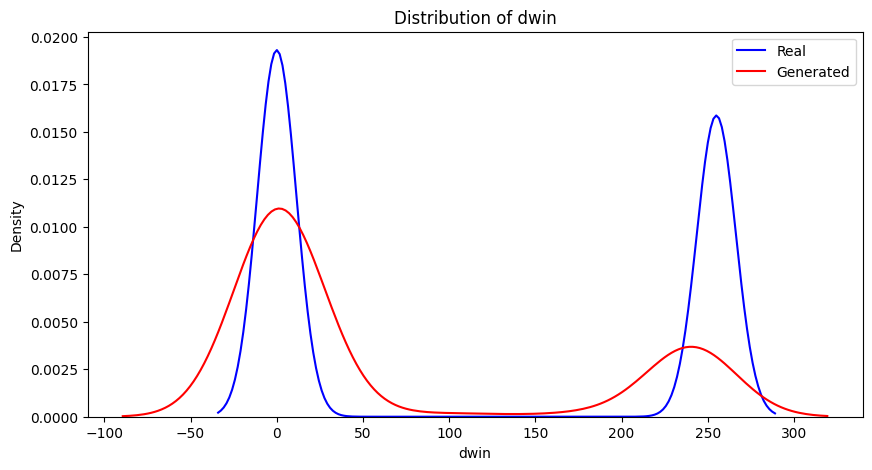

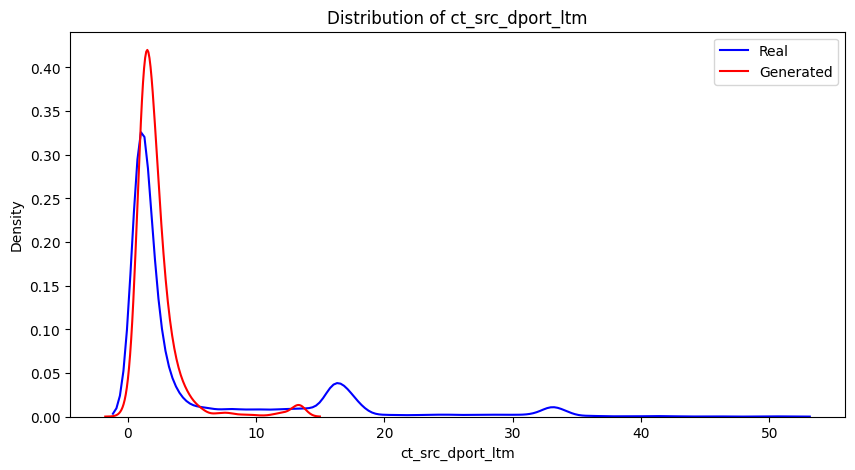

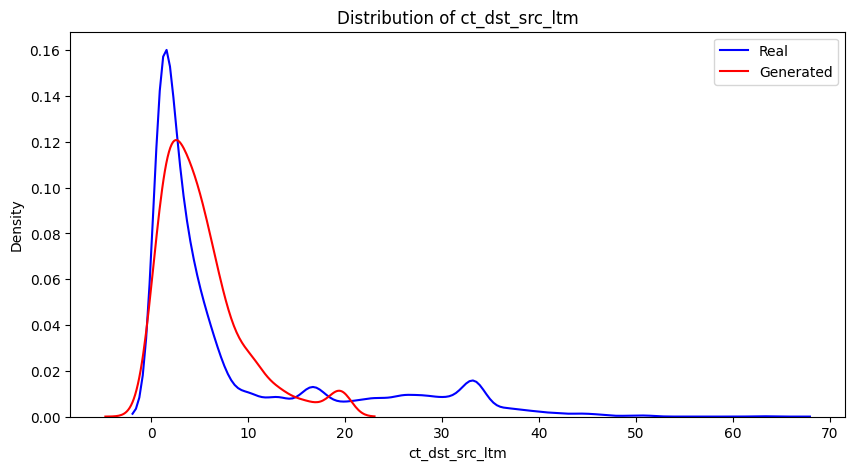

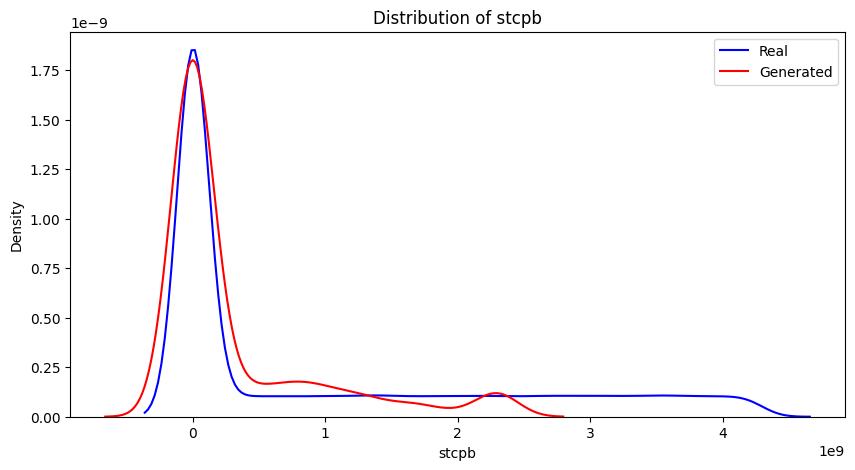

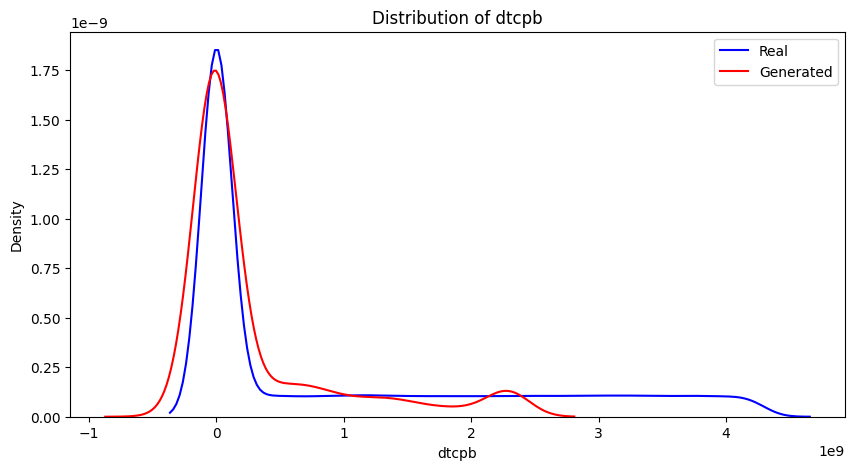

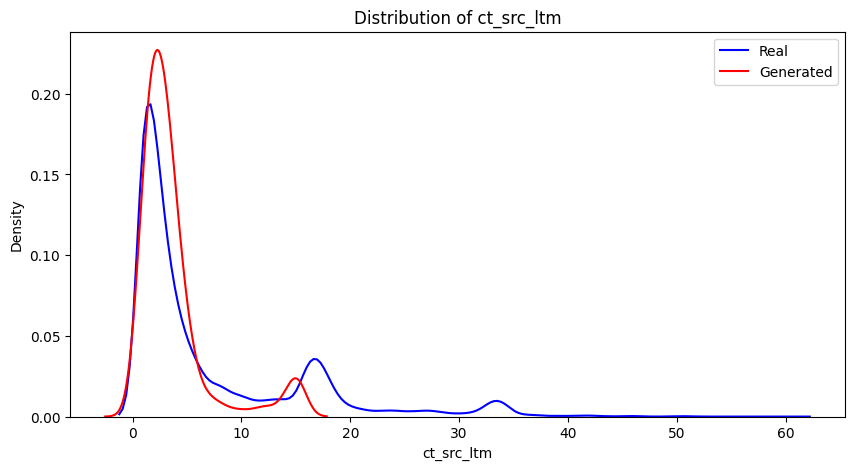

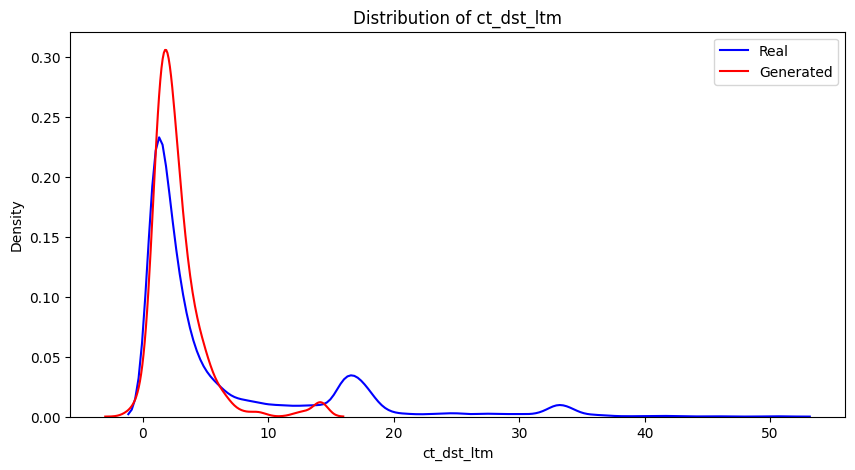

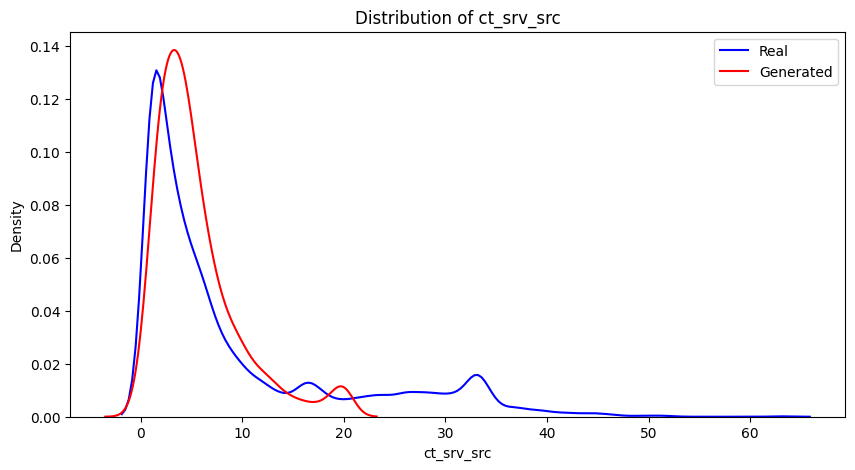

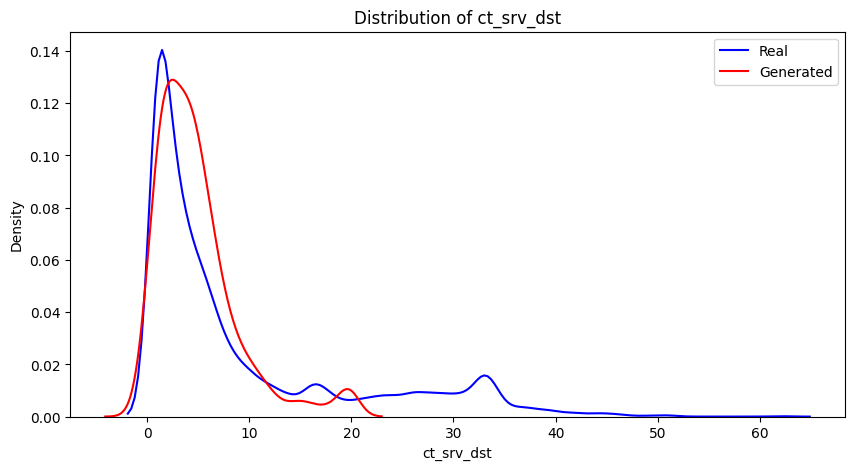

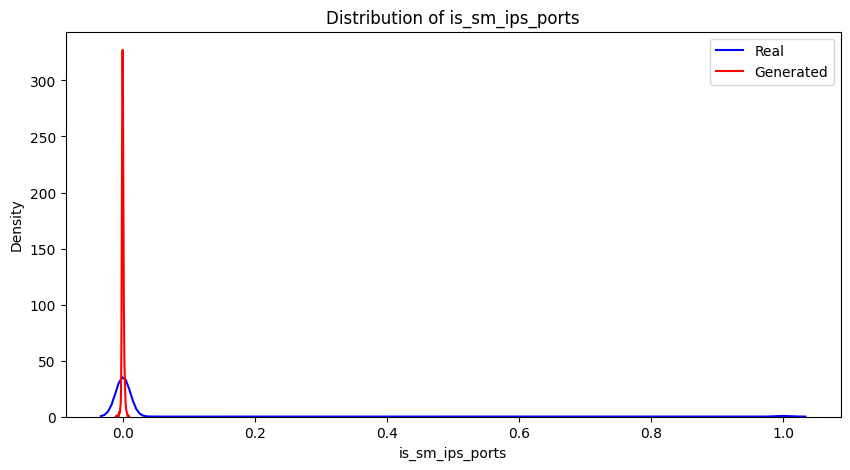

In [12]:
# evaluate the GAN
def evaluate_gan(generator, X_test, latent_dim, n_samples=1000):
    noise = np.random.normal(0, 1, (n_samples, latent_dim))
    generated_data = generator.predict(noise)
    generated_data = scaler.inverse_transform(generated_data)
    generated_df = pd.DataFrame(generated_data, columns=top_features)
    print("Generated Data Sample:\n", generated_df.head())
    # Compare distributions
    for feature in top_features:
        plt.figure(figsize=(10, 5))
        sns.kdeplot(df_train[feature], label='Real', color='blue')
        sns.kdeplot(generated_df[feature], label='Generated', color='red')
        plt.title(f'Distribution of {feature}')
        plt.legend()
        plt.show()

evaluate_gan(generator, X_test, latent_dim, n_samples=1000)

# Save the models
generator.save('generator_model.h5')